In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import corner
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#
import sys
sys.path.append('../../')
import data.datasets as datasets
from models.losses import SupervisedSimCLRLoss
#from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
import data.data_utils as dutils

In [1]:
#np.random.seed(2)
nsigs=4
ndisc=4
nrand=4
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
batch_size = 1000
trainloader = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)
input_dim  = tjds.train_data.shape[1]

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var in range(input_dim):
    if var > 8:
        continue
    _,bins,_=ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == (nsigs-1)].numpy(),density=True,alpha=0.5,label='4')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 0].numpy(),density=True,alpha=0.5,bins=bins,label='1')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 1].numpy(),density=True,alpha=0.5,bins=bins,label='2')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 2].numpy(),density=True,alpha=0.5,bins=bins,label='3')
    ax[var//3,var % 3].set_xlabel("var "+str(var))
    ax[var//3,var % 3].legend()

NameError: name 'datasets' is not defined

In [83]:
#now contrastive model
hidden_dims= [128,64,32,16]
embed_dim  = 4 #not making it smaller than input space
temp = 0.01
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.09s/it]


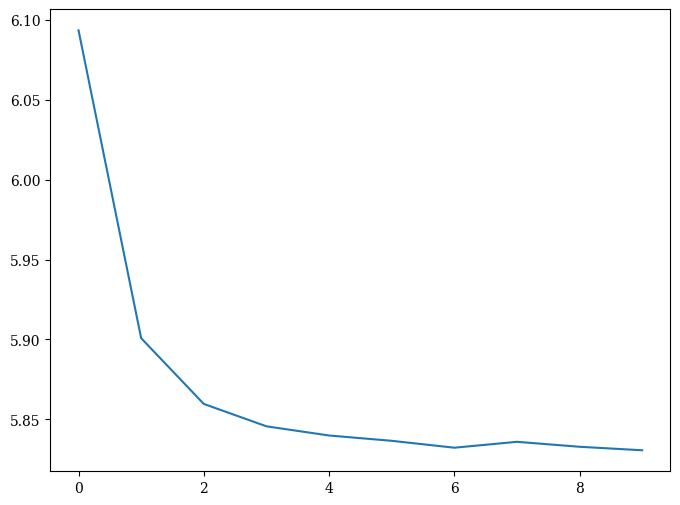

In [87]:
# Training loop
num_epochs = 10
batch_size = 1000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

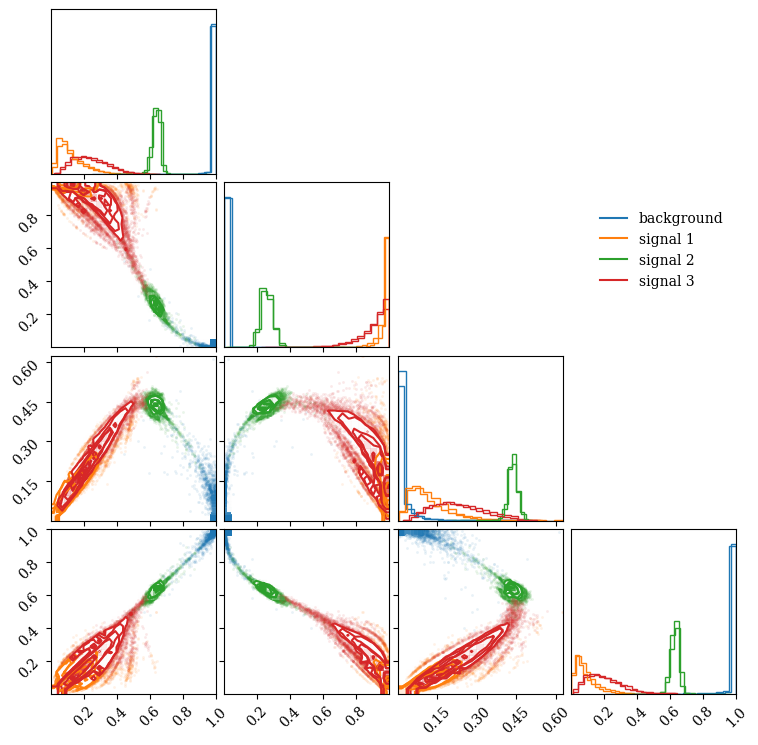

In [88]:
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))

import corner
import matplotlib.lines as mlines
fig = plt.figure(figsize=(8,8))
corner.corner(output[labels==0].numpy(),fig=fig,color="C0", label='background')
corner.corner(output[labels==1].numpy(),fig=fig,color="C1", label='signal 1')
corner.corner(output[labels==2].numpy(),fig=fig,color="C2", label='signal 2')
corner.corner(output[labels==3].numpy(),fig=fig,color="C3", label='signal 3')
corner.corner(output1[labels1==0].numpy(),fig=fig,color="C0", label='data background')
corner.corner(output1[labels1==1].numpy(),fig=fig,color="C1", label='data signal 1')
corner.corner(output1[labels1==2].numpy(),fig=fig,color="C2", label='data signal 2')
corner.corner(output1[labels1==3].numpy(),fig=fig,color="C3", label='data signal 3')
plt.legend(
        handles=[
            mlines.Line2D([], [], color="C0", label='background'),
            mlines.Line2D([], [], color="C1", label='signal 1'),
            mlines.Line2D([], [], color="C2", label='signal 2'),
            mlines.Line2D([], [], color="C3", label='signal 3'),
        ],bbox_to_anchor=(1, 3),frameon=False, loc="upper right"
    )
plt.show()

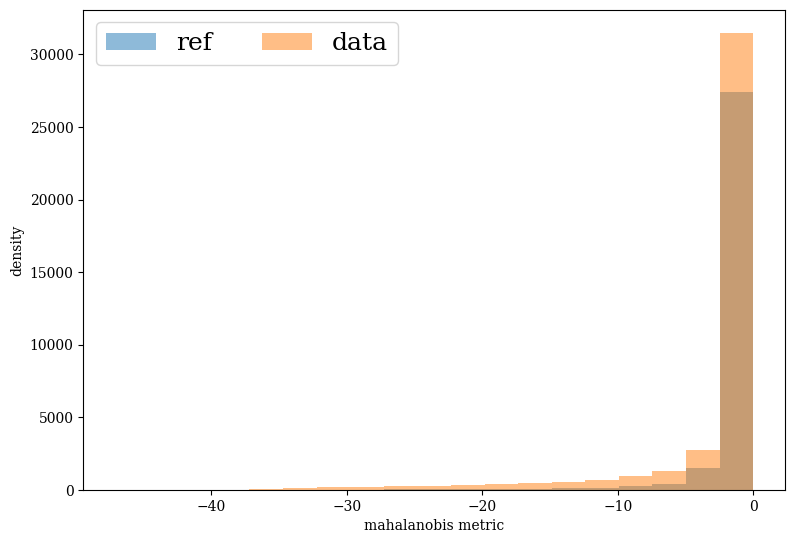

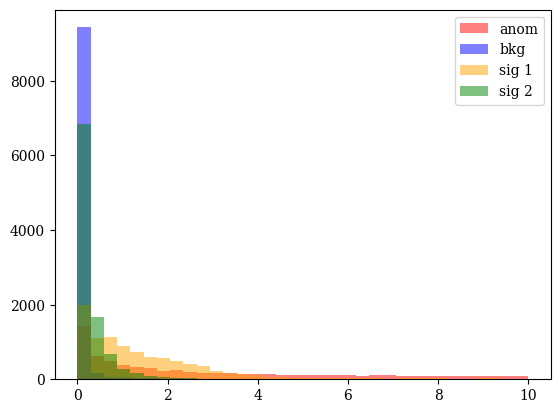

In [89]:
ref=output[labels != (nsigs-1)]
ref_label=labels[labels != (nsigs-1)]
val,dist=dutils.mahalanobis_dist(output,ref,ref_label,fit=False)
#dist.plot()
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
plt.legend()
#plt.yscale('log')

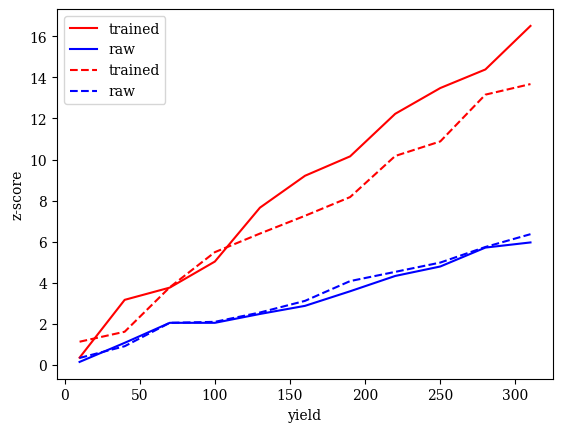

In [90]:
xy1,zscore1=dutils.z_yield(output,         labels,           output,         labels,         (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy2,zscore2=dutils.z_yield(tjds.test_data,tjds.test_labels,tjds.test_data,tjds.test_labels,  (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy1d,zscore1d=dutils.z_yield(output1,         labels1,           output,         labels,     (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy2d,zscore2d=dutils.z_yield(tjds.trut_data,tjds.trut_labels,tjds.test_data,tjds.test_labels,(nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)


plt.plot(xy1,zscore1,c='red',label="trained")
plt.plot(xy2,zscore2,c='blue',label="raw")
plt.plot(xy1d,zscore1d,c='red',linestyle='dashed',label="trained")
plt.plot(xy2d,zscore2d,c='blue',linestyle='dashed',label="raw")
plt.xlabel("yield")
plt.ylabel("z-score")
plt.legend()
plt.show()

[autoreload of data.datasets failed: Traceback (most recent call last):
  File "/Users/philipharris/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 261, in check
    superreload(m, reload, self.old_objects)
  File "/Users/philipharris/miniconda3/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 459, in superreload
    module = reload(module)
  File "/Users/philipharris/miniconda3/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/philipharris/Dropbox/Physics/8S50_2022/test3/phlab-neurips25/experiments/toyjet/../../data/datas

Means: [0, 1.0, 0.6526033600627423, 0.8539642161656037] 
Sigmas: [0.2, 0.2, 0.019299241855689542, 0.04592002962181163]
choice [array([2, 1, 0, 3]), array([2, 1, 0, 3]), array([0, 3, 1, 2]), array([1, 2, 3, 0])]


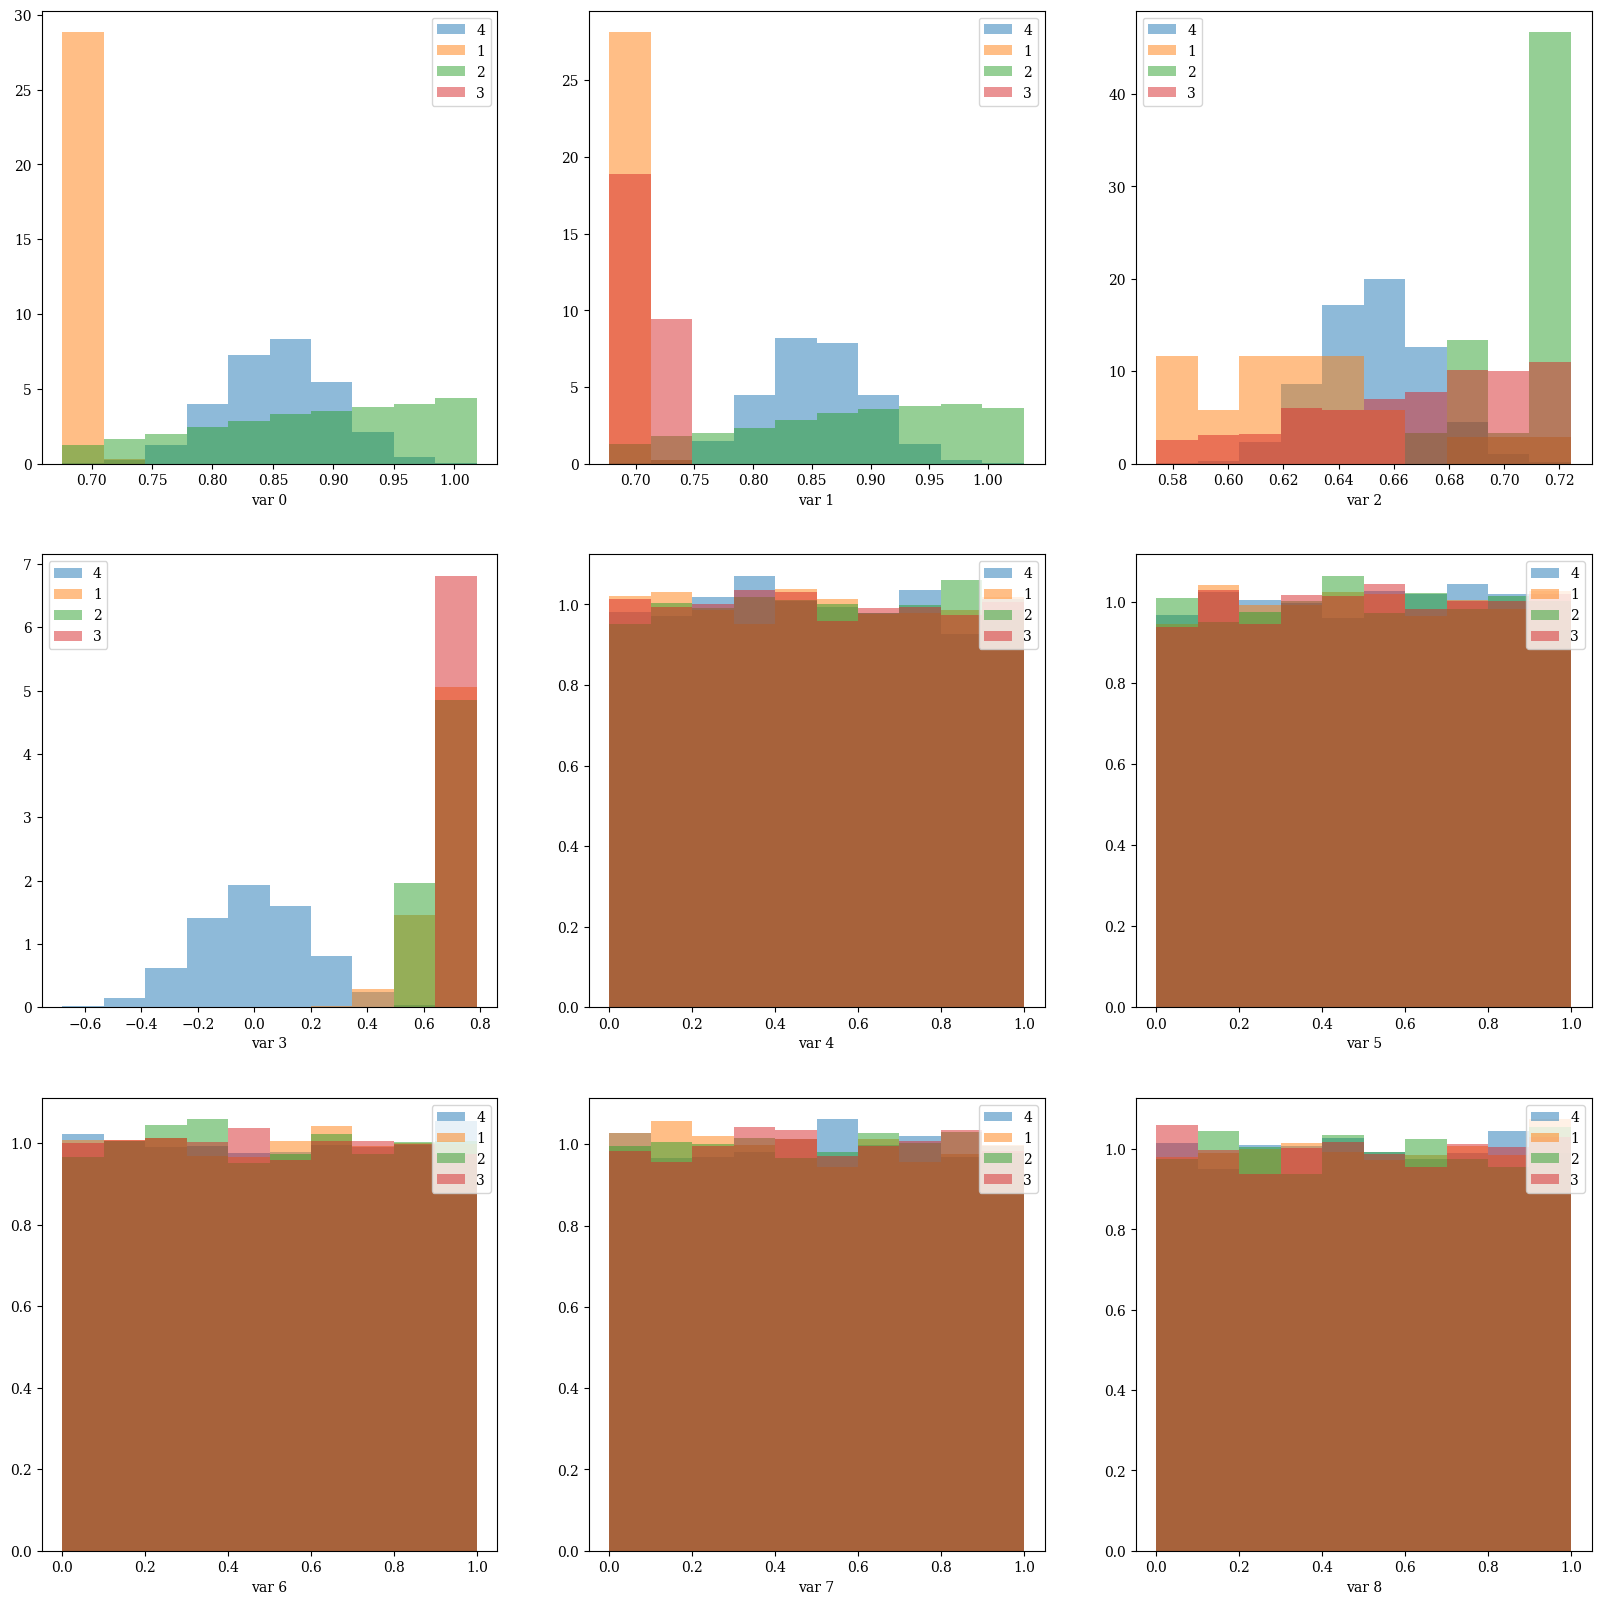

In [102]:
#np.random.seed(2)
nsigs=4
ndisc=4
nrand=12
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
batch_size = 1000
trainloader = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)
input_dim  = tjds.train_data.shape[1]

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var in range(input_dim):
    if var > 8:
        continue
    _,bins,_=ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == (nsigs-1)].numpy(),density=True,alpha=0.5,label='4')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 0].numpy(),density=True,alpha=0.5,bins=bins,label='1')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 1].numpy(),density=True,alpha=0.5,bins=bins,label='2')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 2].numpy(),density=True,alpha=0.5,bins=bins,label='3')
    ax[var//3,var % 3].set_xlabel("var "+str(var))
    ax[var//3,var % 3].legend()

/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/Users/philipharris/miniconda3/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.27s/it]


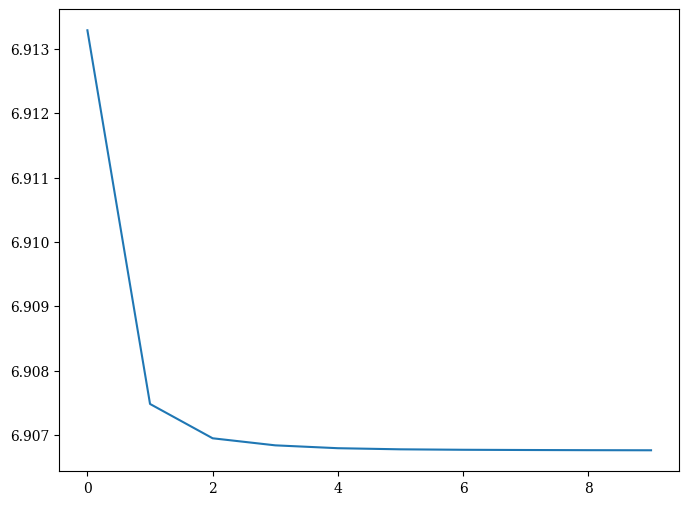

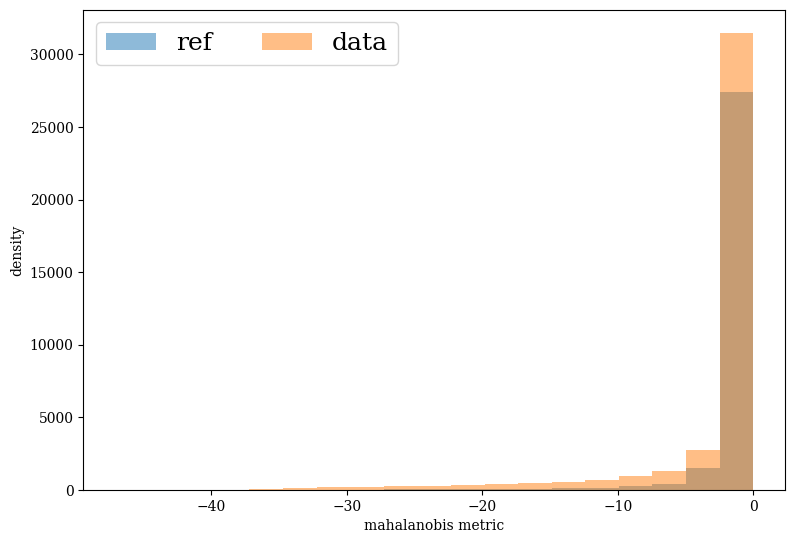

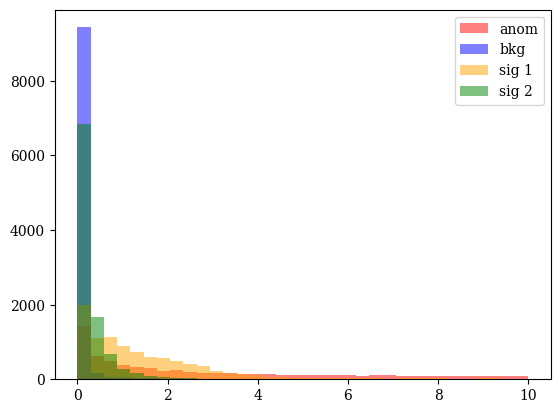

In [92]:
#now contrastive model
hidden_dims= [128,64,32,16]
embed_dim  = 4 #not making it smaller than input space
temp = 0.01
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

# Training loop
num_epochs = 10
batch_size = 1000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)
output = []
labels =tjds.test_labels.int()
labels1=tjds.true_labels.int()
with torch.no_grad():
    output  = (model(tjds.test_data.float(),embed=True))
    output1 = (model(tjds.true_data.float(),embed=True))


ref=output[labels != (nsigs-1)]
ref_label=labels[labels != (nsigs-1)]
val,dist=dutils.mahalanobis_dist(output,ref,ref_label,fit=False)
#dist.plot()
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
plt.legend()
#plt.yscale('log')

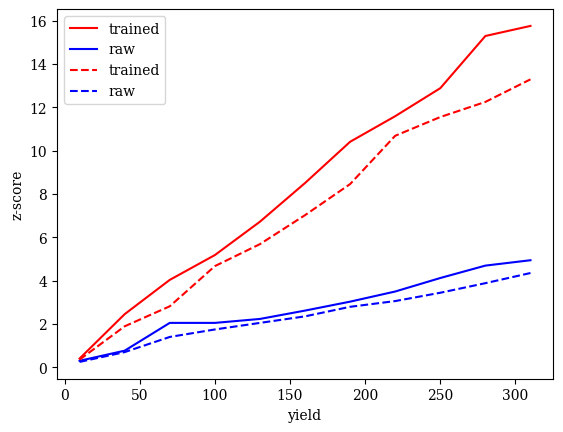

In [93]:
xy1,zscore1=dutils.z_yield(output,         labels,           output,         labels,         (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy2,zscore2=dutils.z_yield(tjds.test_data,tjds.test_labels,tjds.test_data,tjds.test_labels,  (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy1d,zscore1d=dutils.z_yield(output1,         labels1,           output,         labels,     (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy2d,zscore2d=dutils.z_yield(tjds.trut_data,tjds.trut_labels,tjds.test_data,tjds.test_labels,(nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)


plt.plot(xy1,zscore1,c='red',label="trained")
plt.plot(xy2,zscore2,c='blue',label="raw")
plt.plot(xy1d,zscore1d,c='red',linestyle='dashed',label="trained")
plt.plot(xy2d,zscore2d,c='blue',linestyle='dashed',label="raw")
plt.xlabel("yield")
plt.ylabel("z-score")
plt.legend()
plt.show()

Means: [0, 1.0, 0.33729527702174666, 0.8098292764239945] 
Sigmas: [0.2, 0.2, 0.1541793056146849, 0.08338176170607603]
choice [array([1, 2, 3, 0]), array([1, 0, 2, 3]), array([0, 1, 3, 2]), array([2, 0, 1, 3])]


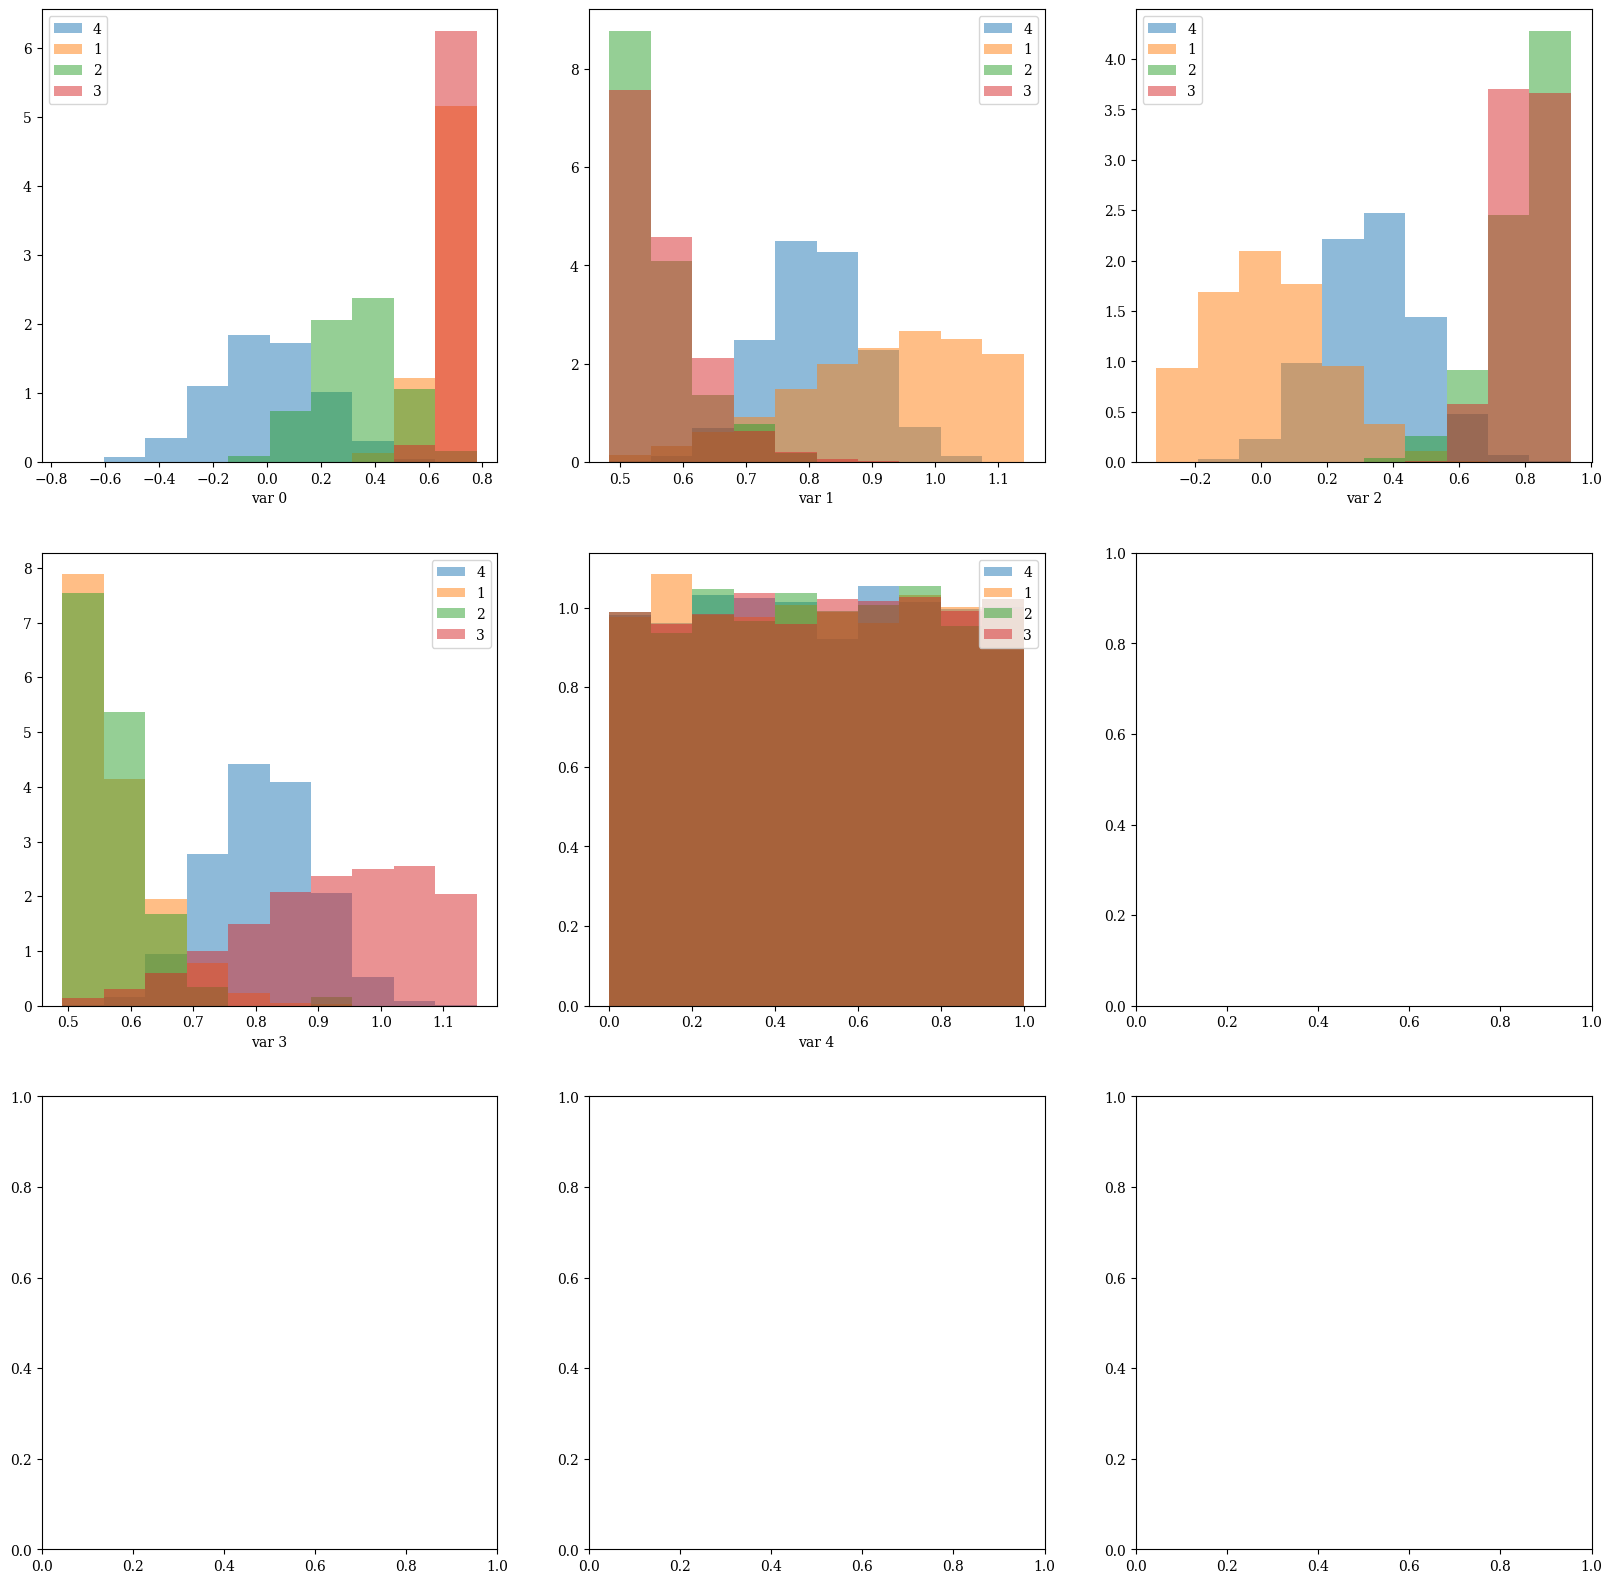

In [94]:
#np.random.seed(2)
nsigs=4
ndisc=4
nrand=1
nj_train   = 10000
nj_valid   = 5
nj_testy   = 10000
tjds       = datasets.FlatDataset(nsigs,ndisc,nj_train,nj_valid,nj_testy,nrand)
batch_size = 1000
trainloader = torch.utils.data.DataLoader(tjds.train_dataset, batch_size=batch_size, shuffle=True)
input_dim  = tjds.train_data.shape[1]

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var in range(input_dim):
    if var > 8:
        continue
    _,bins,_=ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == (nsigs-1)].numpy(),density=True,alpha=0.5,label='4')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 0].numpy(),density=True,alpha=0.5,bins=bins,label='1')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 1].numpy(),density=True,alpha=0.5,bins=bins,label='2')
    ax[var//3,var % 3].hist(tjds.train_data[:,var][tjds.train_labels == 2].numpy(),density=True,alpha=0.5,bins=bins,label='3')
    ax[var//3,var % 3].set_xlabel("var "+str(var))
    ax[var//3,var % 3].legend()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.47s/it]


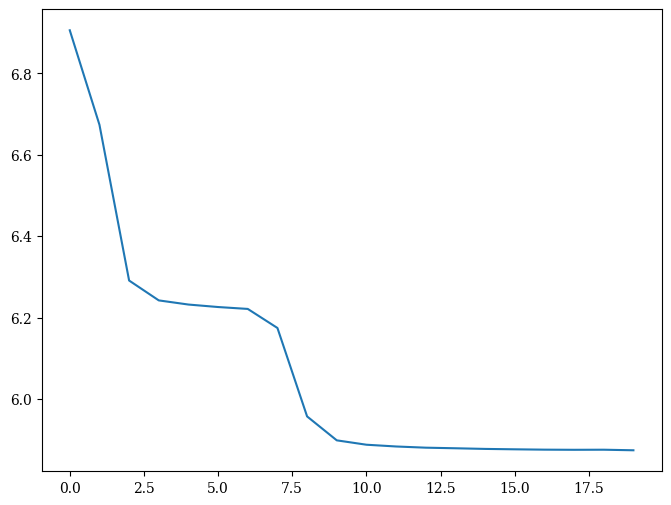

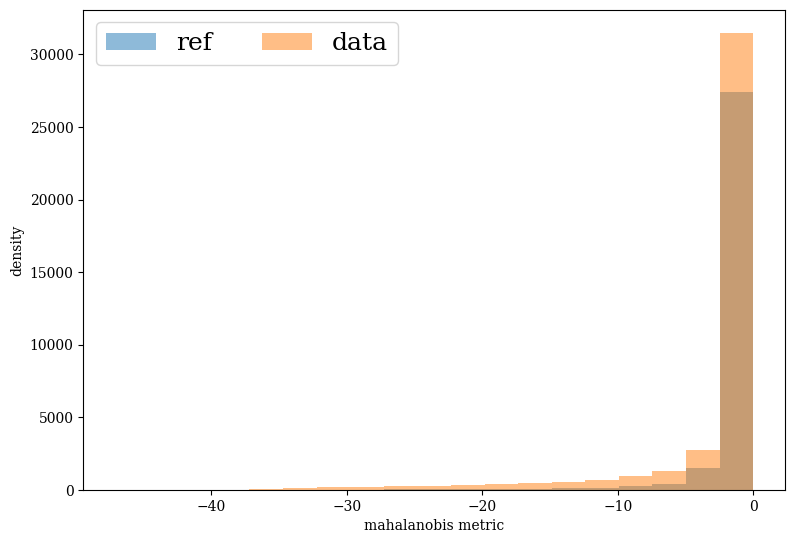

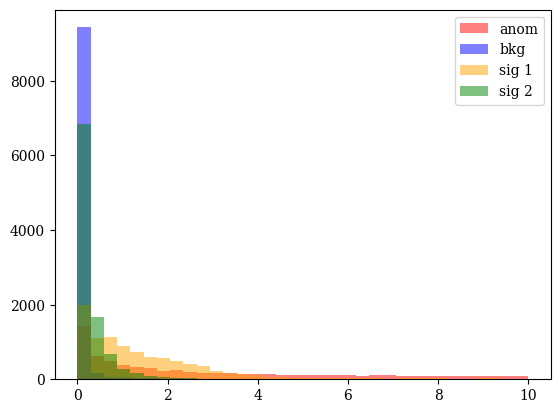

In [100]:
#now contrastive model
hidden_dims= [128,64,32,16]
embed_dim  = 4 #not making it smaller than input space
temp = 0.01
embedder   = MLP(input_dim=input_dim,hidden_dims=hidden_dims,output_dim=embed_dim,output_activation="sigmoid",dropout=0.1)#.to(device)
projector  = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim)
model = SimCLRModel(embedder, projector)
criterion = SupervisedSimCLRLoss(temperature=temp)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.5e-3)

# Training loop
num_epochs = 20
batch_size = 1000
# Dataloaders
trainloader = torch.utils.data.DataLoader(tjds.train_dataset_basic, batch_size=batch_size, shuffle=True)
dutils.train_generic(num_epochs,trainloader,model,criterion,optimizer)

ref=output[labels != (nsigs-1)]
ref_label=labels[labels != (nsigs-1)]
val,dist=dutils.mahalanobis_dist(output,ref,ref_label,fit=False)
#dist.plot()
bins=np.linspace(0,10.,35)
plt.hist(dist[labels==3],bins=bins,alpha=0.5,color='r',label='anom')
plt.hist(dist[labels==0],bins=bins,alpha=0.5,color='b',label='bkg')
plt.hist(dist[labels==1],bins=bins,alpha=0.5,color='orange',label='sig 1')
plt.hist(dist[labels==2],bins=bins,alpha=0.5,color='g',label='sig 2')
plt.legend()
#plt.yscale('log')


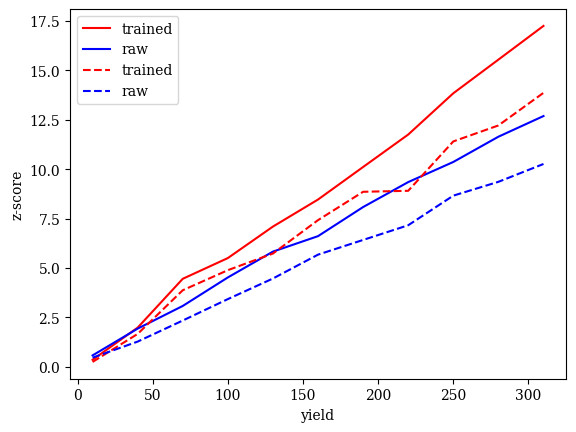

In [101]:
xy1,zscore1=dutils.z_yield(output,         labels,           output,         labels,         (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy2,zscore2=dutils.z_yield(tjds.test_data,tjds.test_labels,tjds.test_data,tjds.test_labels,  (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy1d,zscore1d=dutils.z_yield(output1,         labels1,           output,         labels,     (nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)
xy2d,zscore2d=dutils.z_yield(tjds.trut_data,tjds.trut_labels,tjds.test_data,tjds.test_labels,(nsigs-1),ntoys=50,iNb=10000,iNr=20000,plot=False)


plt.plot(xy1,zscore1,c='red',label="trained")
plt.plot(xy2,zscore2,c='blue',label="raw")
plt.plot(xy1d,zscore1d,c='red',linestyle='dashed',label="trained")
plt.plot(xy2d,zscore2d,c='blue',linestyle='dashed',label="raw")
plt.xlabel("yield")
plt.ylabel("z-score")
plt.legend()
plt.show()